# 演習：Schrödingerの猫を実装する
Schrödingerの猫とは、理論物理学者Erwin Schrödingerによる思考実験です。不透明な箱に、1分間に50%の確率で毒ガスを発生させる装置と猫を入れたとき、1分後の猫の生死がどうなっているかを論じるものです。

ところで、量子状態$ |+\rangle $を測定すると、50%の確率で$ |0\rangle $を、50%の確率で$ |1\rangle $を観測することができます。
$$
|+\rangle = \frac{1}{\sqrt{2}} |0\rangle + \frac{1}{\sqrt{2}} |1\rangle
$$

これを利用し、量子ビットを使ってSchrödingerの猫を実装してみましょう。

## 準備 1: 必要なライブラリをインポートします

In [1]:
#必要なライブラリのインポート
%matplotlib inline
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, IBMQ
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor 
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt

## 準備 2: 生きた猫と死んだ猫を表示する関数を実装します

In [2]:
#猫画像の初期化
live_cat = np.array(
    [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,1,1,0],
    [0,1,1,1,1,1,0,0,0,1,1,0,0,0,1,1,1,1,1,0],
    [0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,0],
    [0,1,1,1,1,0,0,1,0,0,1,0,0,0,1,1,1,1,1,0],
    [0,1,1,1,1,0,0,1,0,0,1,0,0,0,1,1,1,1,1,0],
    [0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0],
    [0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,0,0,0,0,0,1,1,1,0,0,1,1,0],
    [0,1,1,1,1,1,1,1,1,0,0,1,1,1,0,1,1,0,1,0],
    [0,1,1,1,1,1,1,1,1,0,0,0,1,1,0,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,0,0,0,0,1,1,0,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,0,1,1,0],
    [0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,1,1,0],
    [0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,1,0],
    [0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,0],
    [0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
dead_cat = np.array(
    [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0],     
    [0,1,1,1,0,0,1,1,0,0,1,1,1,0,0,0,0,0,1,0],     
    [0,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0],     
    [0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],     
    [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],     
    [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],     
    [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

#入力に0が含まれていると生きている猫、
#含まれていない場合は死んでいる猫が表示される関数
def show_cat(memory):
    if memory[0] == '0':
        image = live_cat
    else:
        image = dead_cat
        
    fig, ax = plt.subplots()
    ax.imshow(image, cmap=plt.cm.gray)
    ax.axis("off")
    plt.show()

`show_cat`関数が正しく動作するか確かめましょう。

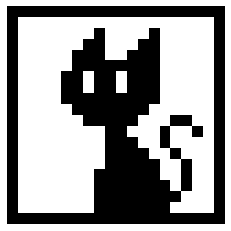

In [3]:
#生きた猫
show_cat(['0'])

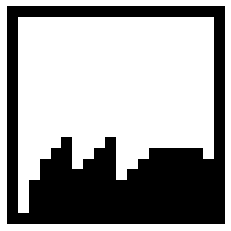

In [4]:
#死んだ猫
show_cat(['1'])

## 演習 1: $|+\rangle$状態を測定する量子回路を作成します
1量子ビット、1古典ビットを持つ量子回路を作成、第0量子ビットにHゲートを作用させて、観測します。

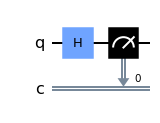

In [5]:
#1量子ビット、１古典ビットの量子回路の作成
qr = QuantumRegister(1, 'q')
cr = ClassicalRegister(1, 'c')
circuit = QuantumCircuit(qr, cr)

# 第0量子ビットにHゲートを作用させる
circuit.h(qr[0])
# 量子回路を測定する
circuit.measure(qr[0],cr[0])
# 量子回路を描画する
circuit.draw()

## 演習 2: 作成した量子回路が正しく動作するか確認します
QasmSimulatorを用いて確かめてみましょう。50%の確率で$|0\rangle$が、50%の確率で$|1\rangle$が観測されることを確認します。

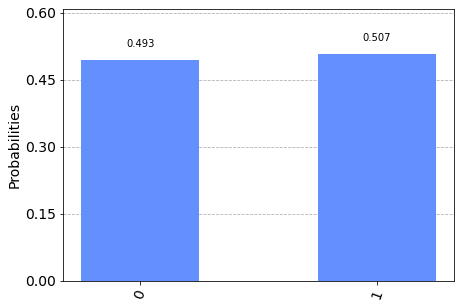

In [6]:
# QasmSimulatorを取得します
backend = QasmSimulator()
# 回路をトランスパイルします
compiled_circuit = transpile(circuit, backend)
# 回路を10000回シミュレーターで実行します
result = backend.run(compiled_circuit, shots=10000).result()
# 実行結果をカウント数として取得します
counts  = result.get_counts(circuit)
# 結果を描画します
plot_histogram(counts)

## 演習 3: シミュレーターを使って実行する
シミュレーターの実行結果を用いて、猫の状態を決定しましょう。何度か実行して、生きている猫と死んでいる猫が表示されることを確認してください。

['0']


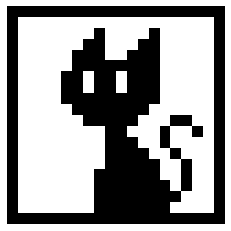

In [7]:
# 回路を1回実行して、結果を取得します。memoryパラメーターをTrueに設定して下さい。
result = backend.run(compiled_circuit, shots=1, memory=True).result()
# 実行結果を個々の測定結果として取得します
memory = result.get_memory(circuit)

# 結果を描画します
print(memory)
show_cat(memory)

## 演習 4: 実機を使って実行する
シミュレーターで動きを確認できたので、実機で動かしてみましょう。まず、回路を実行する実機を探します。

In [8]:
# IBM Qアカウントをロードします
provider = IBMQ.load_account()
# 最も待ち行列が少ない実機を探します
least_busy(provider.backends(filters=lambda x: not x.configuration().simulator))

<IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>

見つけた実機で量子回路を実行します。実行状況をモニターしてください。

In [9]:
# 直前のセルで取得した実機の名前を指定して、実行バックエンドを取得します
backend = provider.get_backend('ibmq_armonk')
# 回路をトランスパイルします
compiled_circuit = transpile(circuit, backend)
# 作成した回路を1回実行して、結果を取得します。memoryパラメーターをTrueに設定して下さい。
job = backend.run(compiled_circuit, shots=1, memory=True)
# 実行状況をモニターします
job_monitor(job)

Job Status: job has successfully run


`Job Status: job has successfully run` と表示されたら、結果を取得し、猫の状態を決定しましょう。

['1']


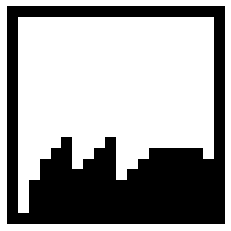

In [10]:
# 実行結果の取得
result = job.result()
# 実行結果を個々の観測結果として取得
memory = result.get_memory(circuit)

# 結果を描画します
print(memory)
show_cat(memory)

以上で、量子ビットを使用したSchrödingerの猫を実装の演習は終わりです。お疲れ様でした！

## 応用
時間内に終わった方は、次の量子状態を利用して、1/3の確率で生きた猫、1/3の確率で死んだ猫、1/3の確率で空の箱(そもそも猫はいなかった)を表示するプログラムを作成してみましょう。

$$
|\psi\rangle = \frac{|01\rangle + |10\rangle + |11\rangle}{\sqrt{3}}
$$

この状態を実現する回路は以下の通りです。なお、$R_y$ゲートの回転角$\theta$は以下の通りです。
$$
\theta = 2 * \arccos{\frac{1}{\sqrt{3}}}
$$

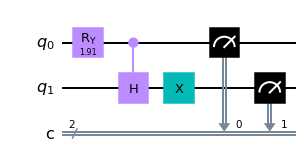

In [11]:
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt

qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(2, 'c')
qc = QuantumCircuit(qr,cr)

theta = 2 * np.arccos(1 / np.sqrt(3))
qc.ry(theta,qr[0])
qc.ch(qr[0],qr[1])
qc.x(qr[1])
qc.measure(qr, cr)
qc.draw()

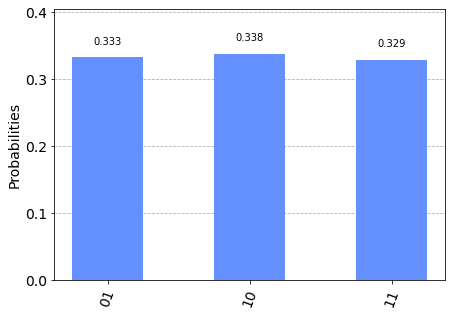

In [12]:
backend = QasmSimulator()
compiled_qc = transpile(qc, backend)
result = backend.run(compiled_qc, shots=10000).result()
counts  = result.get_counts(qc)
plot_histogram(counts)

In [13]:
#空の箱の画像
no_cat = np.array(
    [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

#show_cat関数の拡張
def extended_show_cat(memory):
    if memory[0] == '01':
        image = live_cat
    elif memory[0] == '10':
        image = dead_cat
    else:
        image = no_cat
        
    fig, ax = plt.subplots()
    ax.imshow(image, cmap=plt.cm.gray)
    ax.axis("off")
    plt.show()

In [14]:
# 実装してみましょう！
backend_name = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                             and not x.configuration().simulator)).name()
backend = provider.get_backend(backend_name) 
compiled_qc = transpile(qc, backend)
job = backend.run(compiled_qc, shots=1, memory=True)
job_monitor(job)

Job Status: job has successfully run


['11']


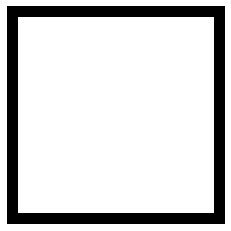

In [15]:
result = job.result()
memory = result.get_memory(qc)

print(memory)
extended_show_cat(memory)

ワークショップ、セッション、および資料は、IBMまたはセッション発表者によって準備され、それぞれ独自の見解を反映したものです。それらは情報提供の目的のみで提供されており、いかなる参加者に対しても法律的またはその他の指導や助言を意図したものではなく、またそのような結果を生むものでもありません。本講演資料に含まれている情報については、完全性と正確性を期するよう努力しましたが、「現状のまま」提供され、明示または暗示にかかわらずいかなる保証も伴わないものとします。本講演資料またはその他の資料の使用によって、あるいはその他の関連によって、いかなる損害が生じた場合も、IBMは責任を負わないものとします。本講演資料に含まれている内容は、IBMまたはそのサプライヤーやライセンス交付者からいかなる保証または表明を引きだすことを意図したものでも、IBMソフトウェアの使用を規定する適用ライセンス契約の条項を変更することを意図したものでもなく、またそのような結果を生むものでもありません。

本講演資料でIBM製品、プログラム、またはサービスに言及していても、IBMが営業活動を行っているすべての国でそれらが使用可能であることを暗示するものではありません。本講演資料で言及している製品リリース日付や製品機能は、市場機会またはその他の要因に基づいてIBM独自の決定権をもっていつでも変更できるものとし、いかなる方法においても将来の製品または機能が使用可能になると確約することを意図したものではありません。本講演資料に含まれている内容は、参加者が開始する活動によって特定の販売、売上高の向上、またはその他の結果が生じると述べる、または暗示することを意図したものでも、またそのような結果を生むものでもありません。パフォーマンスは、管理された環境において標準的なIBMベンチマークを使用した測定と予測に基づいています。ユーザーが経験する実際のスループットやパフォーマンスは、ユーザーのジョブ・ストリームにおけるマルチプログラミングの量、入出力構成、ストレージ構成、および処理されるワークロードなどの考慮事項を含む、数多くの要因に応じて変化します。したがって、個々のユーザーがここで述べられているものと同様の結果を得られると確約するものではありません。

記述されているすべてのお客様事例は、それらのお客様がどのようにIBM製品を使用したか、またそれらのお客様が達成した結果の実例として示されたものです。実際の環境コストおよびパフォーマンス特性は、お客様ごとに異なる場合があります。

IBM、IBM ロゴ、ibm.com、Qiskitは、世界の多くの国で登録されたInternational  Business  Machines  Corporationの商標です。他の製品名およびサービス名等は、それぞれIBMまたは各社の商標である場合があります。現時点でのIBM の商標リストについては、www.ibm.com/legal/copytrade.shtml をご覧ください。